# Find rotation periods of gaia stars and make plots of parallax, etc.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from teff_bv import teff2bv
import barnes as bn
from astropy import units as u
from astropy.coordinates import SkyCoord
import gala.dynamics as gd

In [36]:
def match(id1, id2):
    """
    id1 = small
    id2 = big
    """
    matched = []
    inds1, inds2 = [], []
    for i, id in enumerate(id1):
        m = id2 == id
        if len(id2[m]):
            matched.append(id)
            inds2.append(int(np.where(m)[0]))
            inds1.append(i)
    return matched, inds1, inds2

In [47]:
# load matched tgas catalogue
tgas = pd.read_csv("ruth_matched.csv")

# load Amy's catalogue
rot = pd.read_csv("data/Table_1_Periodic.txt")

# load my catalogue
# kid, periods, localph, rvar, height = np.genfromtxt("kepler_periods.txt").T
kid, periods = np.genfromtxt("kplr_periods.txt").T
print(len(periods), "Kepler-TGAS stars")

# matched, tgas_inds, rot_inds = match(tgas["kepid"], rot["KID"])
matched, tgas_inds, rot_inds = match(tgas["kepid"], kid)

10967 Kepler-TGAS stars


In [48]:
# Create data arrays.
periods = np.array(rot["Prot"])[rot_inds]
teff = np.array(tgas["teff"])[tgas_inds]
logg = np.array(tgas["logg"])[tgas_inds]
feh = np.array(tgas["feh"])[tgas_inds]
pmra = np.array(tgas["pmra"])[tgas_inds]
ra = np.array(tgas["ra"])[tgas_inds]
pmdec = np.array(tgas["pmdec"])[tgas_inds]
dec = np.array(tgas["dec"])[tgas_inds]
parallax = np.array(tgas["parallax"])[tgas_inds]

In [49]:
# calculate B-V color and rotation-age
bv = teff2bv(teff, logg, feh)
age = bn.age(periods, bv)

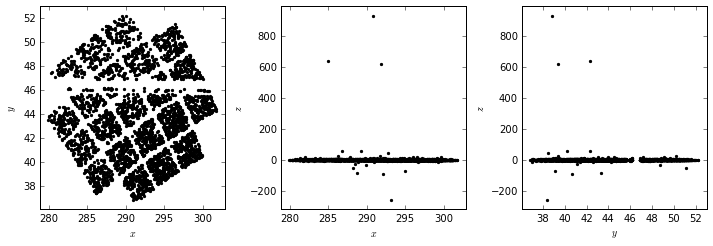

In [50]:
# calculate the z position in Kpc
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=1./parallax*u.kpc)
z = c.cartesian.z
y = c.cartesian.y
x = c.cartesian.x

# calculate velocities
mas2deg = lambda x: x/60/60/1e3
w = gd.CartesianPhaseSpacePosition(pos=[ra*u.deg, dec*u.deg, 1./parallax*u.kpc], vel=[pmra*u.mas/u.year, pmdec*u.mas/u.year, np.zeros_like(pmra)*u.kpc/u.year])
fig = w.plot()

79 stars remaining after cuts


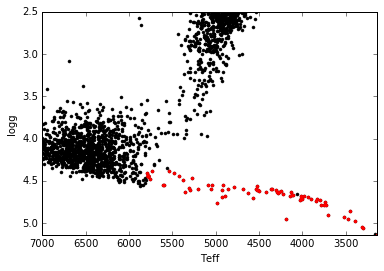

In [51]:
# plot full Kepler-TGAS HR diagram
plt.plot(teff, logg, "k.")
plt.xlim(7000, min(teff))
plt.ylim(max(logg), 2.5)

# remove giants, hot stars and bad data
m = (logg > 4.35) * (teff < 5800) * (parallax > 0)
periods, teff, logg = periods[m], teff[m], logg[m]
pmra, pmdec, parallax = pmra[m], pmdec[m], parallax[m]
bv, age, z = bv[m], age[m], z[m]
ra, dec = ra[m], dec[m]
print(len(periods), "stars remaining after cuts")

# plot HR diagram cuts
plt.plot(teff, logg, "r.")
#plt.xlim(7000, min(teff))
#plt.ylim(max(logg), min(logg))
plt.xlabel("Teff")
plt.ylabel("logg")

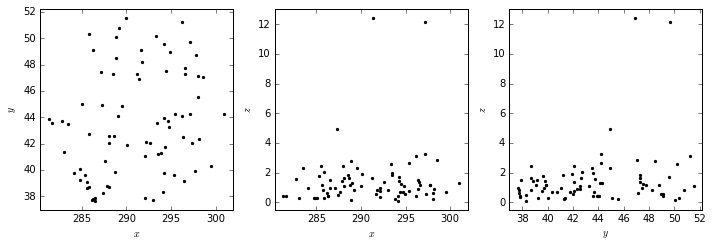

In [52]:
# replot positions
w = gd.CartesianPhaseSpacePosition(pos=[ra*u.deg, dec*u.deg, 1./parallax*u.kpc], vel=[pmra*u.mas/u.year, pmdec*u.mas/u.year, np.zeros_like(pmra)*u.kpc/u.year])
fig = w.plot()

(0, 4)

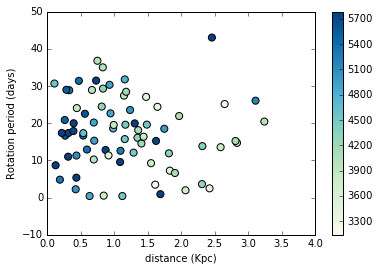

In [57]:
# plot distance vs period
plt.scatter(1./parallax, periods, s=50, c=teff, cmap="GnBu", label="Teff")
plt.colorbar()
plt.xlabel("distance (Kpc)")
plt.ylabel("Rotation period (days)")
plt.xlim(0, 4)

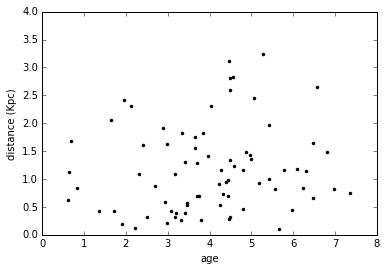

In [56]:
# plot age vs distance
plt.plot(age, 1./parallax, "k.")
plt.ylabel("distance (Kpc)")
plt.ylim(0, 4)
plt.xlabel("age")

(0, 4)

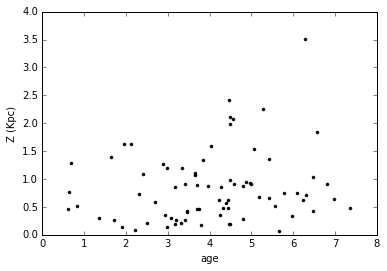

In [58]:
# plot age vs z
plt.plot(age, z, "k.")
plt.ylabel("Z (Kpc)")
plt.xlabel("age")
plt.ylim(0, 4)